### Model dependencies

In [1]:
%load_ext autoreload
%autoreload 2

import sys,time

import midi2audio
import transformers
from transformers import AutoModelForCausalLM

from IPython.display import Audio

from anticipation import ops
from anticipation.sample import generate
from anticipation.tokenize import extract_instruments
from anticipation.convert import events_to_midi, midi_to_events, midi_to_compound_new, compound_to_events, midi_to_compound
from anticipation.visuals import visualize
from anticipation.config import *
from anticipation.vocab import *
from anticipation.vocabs.tripletmidi import vocab

/nlp/scr/npbecker/miniconda3/envs/amt/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
INST_MODEL = '/juice4/scr4/nlp/music/prelim-checkpoints/triplet-live/step-98844/hf/' # new model with instrument conditioning

# load an anticipatory music transformer
model = AutoModelForCausalLM.from_pretrained(INST_MODEL).cuda()

# a MIDI synthesizer
fs = midi2audio.FluidSynth('/usr/share/sounds/sf2/FluidR3_GM.sf2')

# the MIDI synthesis script
def synthesize(fs, tokens):
    mid = events_to_midi(tokens, vocab)
    mid.save('tmp.mid')
    fs.midi_to_audio('tmp.mid', 'tmp.wav')
    return 'tmp.wav'

def synthesize_miditoolkit(fs, mf):
    mf.dump('tmp.mid')
    fs.midi_to_audio('tmp.mid', 'tmp.wav')
    return 'tmp.wav'

### Chorder dependencies

In [3]:
from chorder.chorder import Chord, Dechorder, chord_to_midi, play_chords
from miditoolkit import MidiFile
from copy import deepcopy
chord_program_num = vocab['chord_instrument'] - vocab['instrument_offset']

In [4]:
def extract_human_and_chords(midifile_path, human_program_num=0):
    # Extract human part
    events = midi_to_events(midifile_path, vocab)
    _, human_events = extract_instruments(events, [human_program_num])

    # Harmonize and assign chords to chord_program_num
    mf = MidiFile(midifile_path)
    mf_copy = deepcopy(mf) # chorder operations are in-place
    mf_enchord = Dechorder.enchord(mf_copy)
    mf_chords = play_chords(mf_enchord)
    mf_chords.instruments[0].program = chord_program_num
    mf_chords.dump('tmp.mid')
    chord_events = compound_to_events(midi_to_compound('tmp.mid', vocab, debug=False), vocab)
    _, chord_events = extract_instruments(ops.clip(chord_events, 0, 30), [chord_program_num])

    return (human_events, chord_events)

### Unconditional generation

In [5]:
events = midi_to_events('examples/strawberry.mid', vocab)
list(ops.get_instruments(events).keys())

[0, 35, 53, 128, 29, 25, 43, 117, 61, 104, 119, 75, 73]

In [7]:
import ipdb
from IPython.core.debugger import set_trace

In [79]:
length = 20
unconditional_tokens = generate(model, start_time=0, end_time=length, instruments=[0, 24], top_p=.98)
print(len(unconditional_tokens))

  0%|                                                                            | 0/2000 [00:00<?, ?it/s]

> /juice4/scr4/npbecker/anticipation/anticipation/sample.py(138)add_token()
    137 
--> 138     new_token = []
    139     with torch.no_grad():



ipdb>  n


> /juice4/scr4/npbecker/anticipation/anticipation/sample.py(139)add_token()
    138     new_token = []
--> 139     with torch.no_grad():
    140         for i in range(3):



ipdb>  n


> /juice4/scr4/npbecker/anticipation/anticipation/sample.py(140)add_token()
    139     with torch.no_grad():
--> 140         for i in range(3):
    141             input_tokens = torch.tensor(prefix + history + new_token).unsqueeze(0).to(model.device)



ipdb>  n


> /juice4/scr4/npbecker/anticipation/anticipation/sample.py(141)add_token()
    140         for i in range(3):
--> 141             input_tokens = torch.tensor(prefix + history + new_token).unsqueeze(0).to(model.device)
    142             logits = model(input_tokens).logits[0,-1]



ipdb>  p input_tokens


*** NameError: name 'input_tokens' is not defined


ipdb>  n


> /juice4/scr4/npbecker/anticipation/anticipation/sample.py(142)add_token()
    141             input_tokens = torch.tensor(prefix + history + new_token).unsqueeze(0).to(model.device)
--> 142             logits = model(input_tokens).logits[0,-1]
    143 



ipdb>  p input_tokens


tensor([[55028, 55029, 55053, 55027]], device='cuda:0')


  0%|                                                                            | 0/2000 [00:53<?, ?it/s]

--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by user
0


In [56]:
Audio(synthesize(fs, unconditional_tokens))

Failed to create secure directory (/run/user/20727/pulse): No such file or directory


FluidSynth runtime version 2.1.1
Copyright (C) 2000-2020 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of E-mu Systems, Inc.

Rendering audio to file 'tmp.wav'..


In [80]:
import pickle
with open('logits.pkl', 'rb') as file:
    logits = pickle.load(file)
logits = logits.cpu()

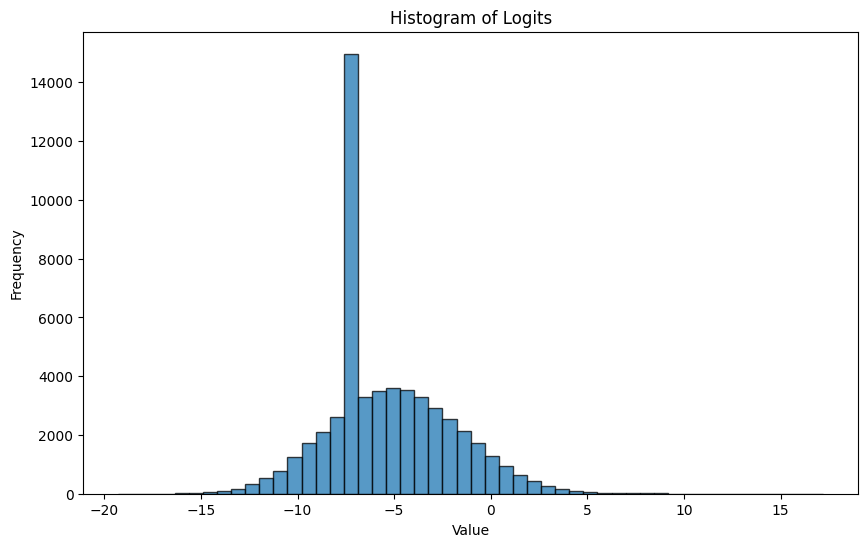

In [82]:
import matplotlib.pyplot as plt
import numpy as np

# Create the histogram
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.hist(logits.numpy(), bins=50, alpha=0.75, edgecolor='black')  # Adjust the number of bins for better granularity

plt.title('Histogram of Logits')  # Add a title to the histogram
plt.xlabel('Value')  # Label for the x-axis
plt.ylabel('Frequency')  # Label for the y-axis

# Display the plot
plt.show()


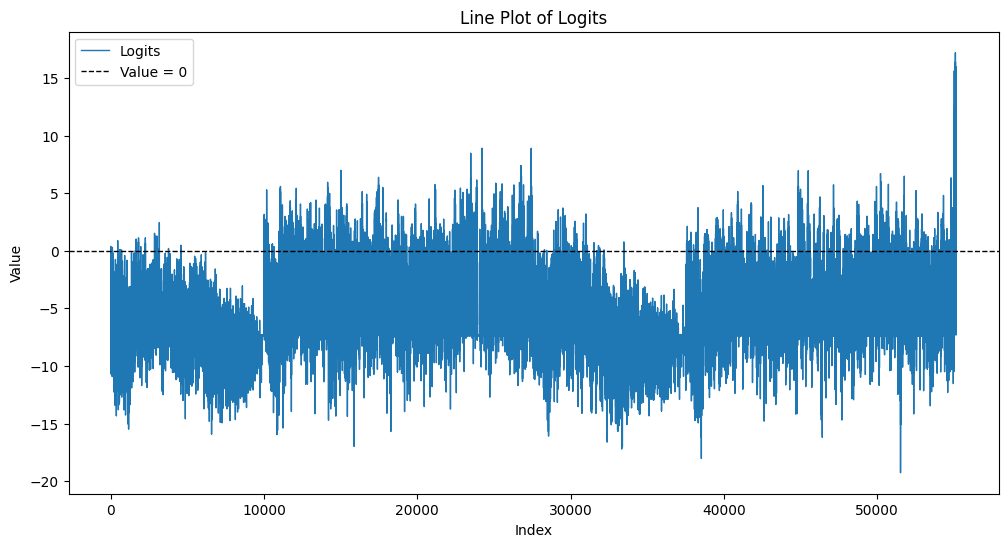

In [83]:
# Generate a line plot
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
plt.plot(logits, label='Logits', linewidth=1)  # Plot 'logits' with a label

plt.title('Line Plot of Logits')  # Add a title to the plot
plt.xlabel('Index')  # Label for the x-axis
plt.ylabel('Value')  # Label for the y-axis

# Draw a horizontal line at value = 0
plt.axhline(y=0, color='black', linestyle='--', linewidth=1, label='Value = 0')

plt.legend()  # Display legend

# Display the plot
plt.show()

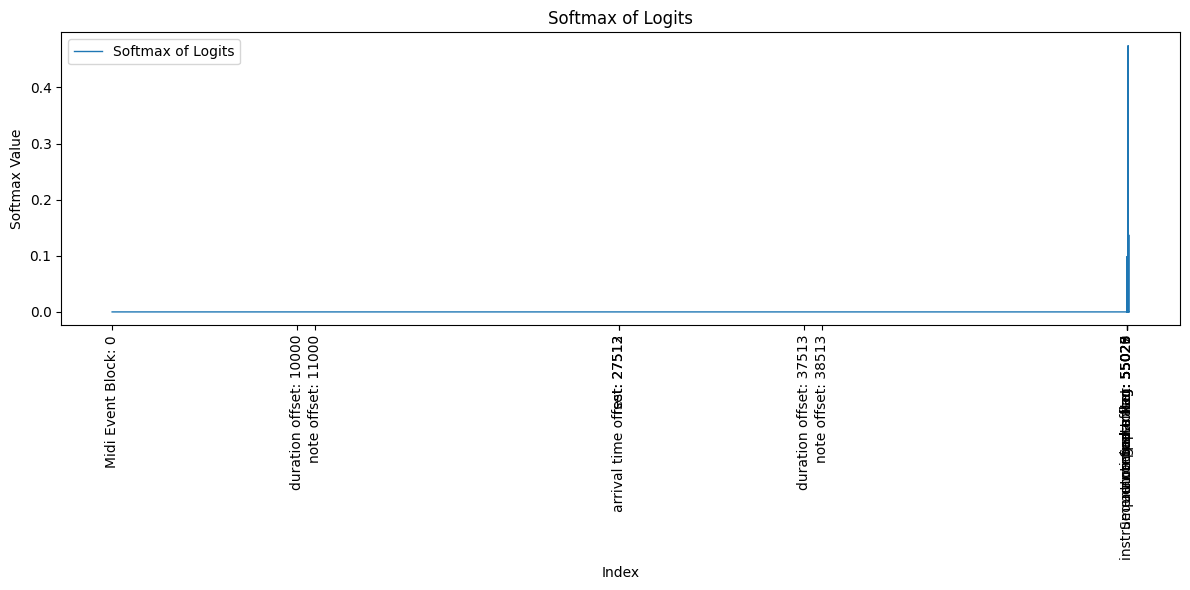

In [84]:
import torch

# Compute softmax of logits using PyTorch
softmax_logits = torch.softmax(logits, dim=0)

# Convert the softmax tensor back to a numpy array for plotting
softmax_logits_np = softmax_logits.numpy()

# Generate a line plot for the softmax values
plt.figure(figsize=(12, 6))
plt.plot(softmax_logits_np, label='Softmax of Logits', linewidth=1)

# Adding custom tick labels with corresponding positions
tick_positions = [0, 55025, 55026, 55027, 55028, 55029, 10000, 11000, 27512, 27513, 37513, 38513]
tick_labels = ['Midi Event Block: 0', 'Sequence Separator: 55025', 
               'autoregress flag: 55026', 'anticipate flag: 55027', 'pad token: 55028', 
               'instrument control offset: 55029', 
               'duration offset: 10000', 'note offset: 11000', 'rest: 27512', 
               'arrival time offset: 27513', 
               'duration offset: 37513', 'note offset: 38513']

# Applying custom tick positions and labels
plt.xticks(tick_positions, tick_labels, rotation=90)  # Rotate labels for better readability

plt.title('Softmax of Logits')
plt.xlabel('Index')
plt.ylabel('Softmax Value')
plt.legend()

plt.tight_layout()
plt.show()

### First example: Strawberry Fields

In [ ]:
events = midi_to_events('examples/strawberry.mid', vocab)
Audio(synthesize(fs, ops.clip(events, 0, 30)))

In [ ]:
human_events, chord_events = extract_human_and_chords('examples/strawberry.mid')

In [ ]:
# Human part
visualize(ops.clip([tk - CONTROL_OFFSET for tk in human_events], 0, 30), '')

In [ ]:
# Chord part
visualize(ops.clip([tk - CONTROL_OFFSET for tk in chord_events], 0, 30), '')

In [ ]:
# What are some reasonable instruments to try? Let's look at the original.
ops.get_instruments(events)

In [ ]:
length = 20
tokens = generate(model, chord_controls=chord_events, human_controls=human_events, start_time=0, end_time=length, instruments=[35, 53, 128, 29, 25, 43, 117], top_p=.98)
print('Tokens generated: ',len(tokens))

In [ ]:
Audio(synthesize(fs, tokens))

In [ ]:
# Let's try with a prompt
length = 30
tokens = generate(model, inputs=ops.clip(events, 0, 10), chord_controls=chord_events, human_controls=human_events, start_time=0, end_time=length, instruments=[35, 53, 128, 29, 25, 43, 117], top_p=.98)
print('Tokens generated: ',len(tokens))

In [ ]:
Audio(synthesize(fs, tokens))